# Practice 2: Indetification of gender using bag-of-words classificiation
Tvrtko Zadro

First we need to import all packages that will be used, mostly *sklearn*'s machine learning models.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
from re import sub
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.model_selection import KFold

Helper function *compute_accuracy* takes for an argument takes set of correct labels *Y_* and set of predicted labels *Y* and returns accuraccy of prediction.

In [2]:
def compute_accuracy(Y_, Y):
    num_correct = sum([y_ == y for y_, y in zip(Y_, Y)])
    num_total = len(Y_)
    
    return num_correct / num_total

Function *find_most_frequent* finds *N* most frequent words in set of files identified by *paths*. Function first makes a dictionary to store number of occurences of every word. Then goes through every file and splits it by spaces, takes every word and cleans it to get lowercase version without special characters. It then updates dictionary. At the end of the proces, we take all dictionary items. Representation is a list where every element is tuple *(word, number_of_occurences)*, we then do descending sort on the list and first *N* elements of the list will be *N* most frequent words in given documents.

In [3]:
def find_most_frequent(paths, N):
    dictionary = {}
    
    for path in paths:
        with open(path, 'r', encoding = 'latin-1') as file:
            for line in file:
                for word in line.split(' '):
                    clean_word = sub(r'\W+', '', word).lower()  # clean word
                    
                    if clean_word == '':  # if it's empty skip
                        continue
                    
                    if clean_word not in dictionary:  # if it's first time create new entry
                        dictionary[clean_word] = 0
                    
                    dictionary[clean_word] += 1  # update occurence
    
    by_frequency = sorted(dictionary.items(), reverse=True, key=lambda x: x[1])  # sort descending
    most_frequent = map(lambda x: x[0], by_frequency[:N])  # take only first N words
    return list(most_frequent)

Function *calculate_features* calculates features for multiple documents.
It takes list of document *paths* as first argument and list of *most_frequent* words as the other. *most_frequent* will actually be only words we will be looking for in every document and it's size determines the size of example's feature vector. Every document in *paths* represents one example and it's name is used to determine it's gender label.
Function returns data ready to be used by *sklearn*'s machine learning models. This means method will return return two-dimensional array *X* which represents feature vectors for dataset. *X* is of shape *[n][N]* where *n* is number of examples (documents) and *N* is number of most frequent words observed (size of feature vector). Array *Y_* are labels for those examples, list of string where each example can either be *female* or *male*. *Y_[i]* represents label for example *X[i]*.

In [4]:
def calculate_features(paths, most_frequent):
    X = []
    Y_ = []
    
    N = len(most_frequent)
    for path in paths:  # for every document (example)
        label = path.split('_')[-1]  # take label
        Y_.append(label)  # add it to labels
        
        total = 0  # track total number of words in document
        features = [0] * N  # feature vector size is determined by number of most frequent words we track
        
        with open(path, 'r', encoding = 'latin-1') as file:
            for line in file:
                for word in line.split(' '):
                    total += 1  # update total number of words
                    clean_word = sub(r'\W+', '', word).lower()  # clean word
                    
                    if clean_word not in most_frequent:  # if it is not one of the most frequent continue
                        continue
                    
                    features[most_frequent.index(clean_word)] += 1  # update occurence
        
        features = [f / total for f in features]  # divide every number of occurences by total number of words to get percentage
        X.append(features)  # add feature vector to list of examples
    
    return np.array(X), np.array(Y_)

Helper function *fit_and_compute_accuracy* takes for arguments *sklearn*'s machine learning *model*, training set and test set. It then fits the model with training set and returns accuracy of it's prediction for test set.

In [5]:
def fit_and_compute_accuracy(model, X_train, Y_train, X_test, Y_test):
    model.fit(X_train, Y_train)  # fit
    Y = model.predict(X_test)  # predict
    return compute_accuracy(Y_test, Y)  # evaluate

Constants for this example. *Ns* represents all sizes of feature vectors we will check and *n_splits* marks number of splits we will use for our K-fold cross validation.

In [6]:
colors = ['red', 'green', 'blue', 'magenta', 'orange', 'purple', 'cyan']
data_dir = 'dataset'
Ns = [5, 10, 20, 50, 100, 150, 200, 300]
n_splits = 10

First we find most frequent words in our dataset. To make sure we don't have to redo this process for every *N* (because it's really time consuming), we will find *N* most frequent words for biggest *N* and later only take subset of these to test for smaller *N*'s, since *N* does not affect word frequency.
*N* also does not affect size of each dimension of the feature vector, only it's size. Because of that we can do the same thing, calculate features for biggest *N* and later take only it's subset.
Size of each dimension of feature vector represents percentage of occurance for word dimension represents in the whole text, that's why it is not affected by *N*. If it were percentage of occurance only in contrast to most frequent words, then we wouldn't be able to do this.

In [7]:
data_paths = [data_dir + '/' + file for file in listdir(data_dir)]

most_frequent = find_most_frequent(data_paths, Ns[-1])
X, Y_ = calculate_features(data_paths, most_frequent)

Here we populate list of *sklearn*'s machine learning models we will test. Every element in the list is represented by a touple *(model, name)* so we can later correctly label models in our graph.

In [8]:
models = []
models.append((BaggingClassifier(KNeighborsClassifier(), max_samples=0.5, max_features=0.5), 'Bagging'))
models.append((RandomForestClassifier(n_estimators=10), 'Random Forest'))
models.append((AdaBoostClassifier(n_estimators=100), 'AdaBoost'))
models.append((GaussianNB(), 'Gaussian NB'))
models.append((MultinomialNB(), 'Multinomial NB'))
models.append((SVC(), 'SVC'))
models.append((LinearSVC(), 'Linear SVC'))

Here we do our K-fold cross validation, and calculate average accuracies for every model for every *N*.

In [9]:
accuracies = np.empty((len(models), len(Ns), n_splits))
for i, N in enumerate(Ns):  # for every N
    kf = KFold(n_splits=n_splits)  # create k-fold
    for j, (train, test) in enumerate(kf.split(X, Y_)):  # done n_k times where n_k is number of folds
        X_train, Y_train = X[train,:N], Y_[train]  # take only N columns of feature vectors
        X_test, Y_test = X[test,:N], Y_[test]  # same as above
        
        for k, (model, _) in enumerate(models):  # for every model check accuracy
            accuracies[k][i][j] = fit_and_compute_accuracy(model, X_train, Y_train, X_test, Y_test)
accuracies = np.sum(accuracies, axis=2) / n_splits  # sum all accuracies for every N for every model and divide by number of splits to get average

Finally, we plot a graph showing how well each of the different models predicts geneder of text author. We can note that models obviously behave better for bigger feature vectors. My guess is it is because dimensionality is bigger and it is easier to find decision function that splits both classes.

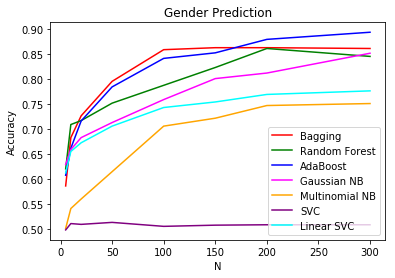

In [10]:
for i, (_, name) in enumerate(models):
    plt.plot(Ns, accuracies[i], label=name, c=colors[i])
plt.title('Gender Prediction')
plt.xlabel('N')
plt.ylabel('Accuracy')
plt.legend()
plt.show()